# Example from https://github.com/vithursant/VAE-Gumbel-Softmax/blob/master/notebooks/concrete_distribution.ipynb https://blog.evjang.com/2016/11/tutorial-categorical-variational.html

In [30]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import holoviews as hv
%reload_ext holoviews.ipython
%output size=150 fig='svg'

# The Gumbel Distribution

In [31]:
rand_num_genertor = np.random.RandomState(26)

In [32]:
def gumbel_dist(*args):
    u = rand_num_genertor.rand(*args)
    return -np.log(-np.log(u))

In [33]:
hv.Histogram(np.histogram(gumbel_dist(100000), bins=50))

:Histogram   [x]   (Frequency)

# Gumbel-max Trick
https://www.zhihu.com/question/62631725

$$给定一个n维概率向量\pi，我们可以这样对\pi对应的离散随机变量X_\pi取样：$$

$$ X_\pi = argmax(log(\pi_k)+G_k) $$

$$其中G_k是i.i.d 的满足标准 Gumbel distribution 的随机变量。
Gumbel distribution 的 CDF 为F(x;\mu)=e^{-e^{-(x-\mu)}}当\mu为 0时视为标准 Gumbel distribution 。
要验证这样取样得到的随机变量与\mathbb P_\pi对应的随机变量一样，我们只需要验证P(X_\pi=k) = \pi_k即可，即P(log(\pi_k)+G_k\geq log(\pi_i)+G_i;\forall i\neq k)=\pi_k,因为log(\pi_k)为常数，可以设G'_k=G_k+log(\pi_k)， CDF也做相应的变换，经过计算可验证其对任意的成立$$

$$于是我们得到了另外一种作用在(f, G)上的 reparameterization trick ，事实上，G_k=-log(-log(U)), U \sim U(0,1)（这是因为X=F^{-1}(z); z\sim U(0, 1)），将其代入X_\pi得到的其实就是第一段中的f_\pi(z)，只不过用显式写了出来。$$

In [34]:
def softmax(x, axis=None):
    x = np.exp(x)
    return (x/np.sum(x, axis=axis))

In [35]:
print(rand_num_genertor.rand(4))
alpha = 3*rand_num_genertor.rand(4)
print(alpha)
print(softmax(alpha))

[0.99642281 0.19386559 0.77522511 0.35910529]
[2.56603372 1.99410782 1.1847597  1.40762705]
[0.46955375 0.26503367 0.11797925 0.14743333]


In [36]:
hv.Histogram(np.histogram(gumbel_dist(100000), bins=50))\
*hv.VLine(np.log(alpha)[0])*hv.VLine(np.log(alpha)[1])\
*hv.VLine(np.log(alpha)[2])*hv.VLine(np.log(alpha)[3])

:Overlay
   .Histogram.I :Histogram   [x]   (Frequency)
   .VLine.I     :VLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .VLine.III   :VLine   [x,y]
   .VLine.IV    :VLine   [x,y]

In [37]:
%opts Histogram (alpha=0.5)
diff_hists = hv.HoloMap(kdims=['Alpha'])

for i in range(len(alpha)):
    diff_hists[i] = hv.Histogram(np.histogram(np.log(alpha[i])\
                        + gumbel_dist(10000), bins=50))
    
diff_hists.overlay('Alpha')

:NdOverlay   [Alpha]
   :Histogram   [x]   (Frequency)

In [38]:
def gumbel_max(alpha, N=100000):
    d = len(alpha)
    return np.argmax(np.log(alpha.reshape(d,1)) + gumbel_dist(d*N).reshape(d,N),axis=0)

def count(counts):
    bins = {i:0 for i in range(max(counts)+1)}
    for i in bins:
        for c in counts:
            if i == c:
                bins[i] += 1
    return [float(bins[i]) for i in range(max(counts)+1)]

In [39]:
samples = gumbel_max(alpha)
print("Some samples from our categorical:", samples[:10])

Some samples from our categorical: [0 3 2 1 1 3 0 0 1 1]


In [40]:
proportions = count(samples)/np.sum(count(samples))
print("Proportions observed in our samples:", proportions)
print("Probabilities we expected:", alpha/np.sum(alpha))

Proportions observed in our samples: [0.3616  0.27769 0.16457 0.19614]
Probabilities we expected: [0.35875898 0.27879761 0.16564209 0.19680133]


# Concrete Distributions

In [41]:
def gumbel_softmax(alpha, temperature=1, N=100000):
    lmbda = temperature
    d = len(alpha)
    return softmax((np.log(alpha.reshape(d,1)) + gumbel_dist(d*N).reshape(d,N))/lmbda,axis=0)

In [42]:
samples = gumbel_softmax(alpha)
gumbel_softmax(alpha,N=1000).T[0]

array([0.00518551, 0.00287598, 0.97071209, 0.02122641])

In [43]:
def barycentric(p):
    x = 0.0
    y = 0.0
    y += p[1]
    y += p[2]
    x += p[2]
    x += p[3]
    return x,y

In [44]:
barycentric(gumbel_softmax(alpha, N=1000).T[0])

(0.8116973830487831, 0.027787366784173873)

In [45]:
points = np.array([barycentric(s) for s in gumbel_softmax(alpha, N=100000).T])
h = np.histogram2d(points[:,1], points[:,0], bins=20)
hv.QuadMesh((h[1], h[2], h[0])).hist()

:AdjointLayout
   :Histogram   [z]   (z_frequency)
   :QuadMesh   [x,y]   (z)

In [46]:
vary_temperature = hv.HoloMap(kdims=['Lambda'])
for l in np.linspace(0.5, 5.0, 10):
    points = np.array([barycentric(s) for s in gumbel_softmax(alpha, temperature=l, N=100000).T])
    h = np.histogram2d(points[:,1], points[:,0], bins=20)
    vary_temperature[l] = hv.QuadMesh((h[1], h[2], h[0]))

In [47]:
vary_temperature.layout('Lambda').cols(2)

:NdLayout   [Lambda]
   :QuadMesh   [x,y]   (z)

# The example of Gumbel-VAE from the paper's author Eric Jamg

In [48]:
import tensorflow as tf

In [49]:
def sample_gumbel(shape, eps=1e-20): 
    """Sample from Gumbel(0, 1)"""
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax( y / temperature)

In [50]:
def gumbel_softmax(logits, temperature, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar
        hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
        [batch_size, n_class] sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot, otherwise it will
        be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y

In [51]:
from tensorflow.examples.tutorials.mnist import input_data
#one hot encoding returns an array of zeros and a single one. One corresponds to the class
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


## tensorflow slim practice
http://blog.csdn.net/mao_xiao_feng/article/details/73409975

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
slim=tf.contrib.slim

In [53]:
Bernoulli = tf.contrib.distributions.Bernoulli

K=10 # number of classes
N=30 # number of categorical distributions

# input image x (shape=(batch_size,784))
x = tf.placeholder(tf.float32,[None,784])
# variational posterior q(y|x), i.e. the encoder (shape=(batch_size,200))
net = slim.stack(x,slim.fully_connected,[512,256])
# unnormalized logits for N separate K-categorical distributions (shape=(batch_size*N,K))
logits_y = tf.reshape(slim.fully_connected(net,K*N,activation_fn=None),[-1,K])

q_y = tf.nn.softmax(logits_y)
log_q_y = tf.log(q_y+1e-20)

Next, we sample from the Gumbel-Softmax posterior and decode it back into our MNIST image.

In [71]:
# temperature
tau = tf.Variable(1.0,name="temperature")

# sample and reshape back (shape=(batch_size,N,K))
# set hard=True for ST Gumbel-Softmax
y = tf.reshape(gumbel_softmax(logits_y,tau,hard=False),[-1,N,K])
# generative model p(x|y), i.e. the decoder (shape=(batch_size,200))
net = slim.stack(slim.flatten(y),slim.fully_connected,[256,512])
logits_x = slim.fully_connected(net,784,activation_fn=None)
output_img = tf.nn.sigmoid(logits_x)
# (shape=(batch_size,784))
p_x = Bernoulli(logits=logits_x)

Variational autoencoders minimizes reconstruction error of the data by maximizing an expectedlower bound (ELBO) on the likelihood of the data, under a generative model pθ(x). 

$$ logp_\theta(x) \geq  \mathbb E_{q_\phi(y|x)}[logp_\theta(x|y)]-KL[q_\phi(y|x)|p_\theta(y)]$$

$$D_{{{\mathrm  {KL}}}}(P\|Q)=\sum _{i}P(i)\ln {\frac  {P(i)}{Q(i)}}.\!$$

## https://blog.evjang.com/2016/08/variational-bayes.html

In [72]:
# loss and train ops
kl_tmp = tf.reshape(q_y*(log_q_y-tf.log(1.0/K)),[-1,N,K])
KL = tf.reduce_sum(kl_tmp,[1,2])
elbo=tf.reduce_sum(p_x.log_prob(x),1) - KL

In [73]:
loss=tf.reduce_mean(-elbo)
lr=tf.constant(0.001)
train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=slim.get_model_variables())
init_op=tf.global_variables_initializer()

#data.train.images
BATCH_SIZE=100
NUM_ITERS=50000
tau0=1.0 # initial temperature
np_temp=tau0
np_lr=0.001
ANNEAL_RATE=0.00003
MIN_TEMP=0.5

dat=[]
sess=tf.InteractiveSession()
sess.run(init_op)
for i in range(1,NUM_ITERS):
    np_x,np_y=data.train.next_batch(BATCH_SIZE)
    _,np_loss=sess.run([train_op,loss],{x:np_x,tau:np_temp,lr:np_lr})
    if i % 100 == 1:
        dat.append([i,np_temp,np_loss])
    if i % 1000 == 1:
        np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
        np_lr*=0.9
    if i % 5000 == 1:
        print('Step %d, ELBO: %0.3f' % (i,-np_loss))

Step 1, ELBO: -545.031
Step 5001, ELBO: -109.945
Step 10001, ELBO: -110.539
Step 15001, ELBO: -108.579
Step 20001, ELBO: -101.492
Step 25001, ELBO: -101.869
Step 30001, ELBO: -99.214
Step 35001, ELBO: -97.968
Step 40001, ELBO: -104.225
Step 45001, ELBO: -102.887


debug
<class 'numpy.ndarray'>
(3000, 10)
debug2


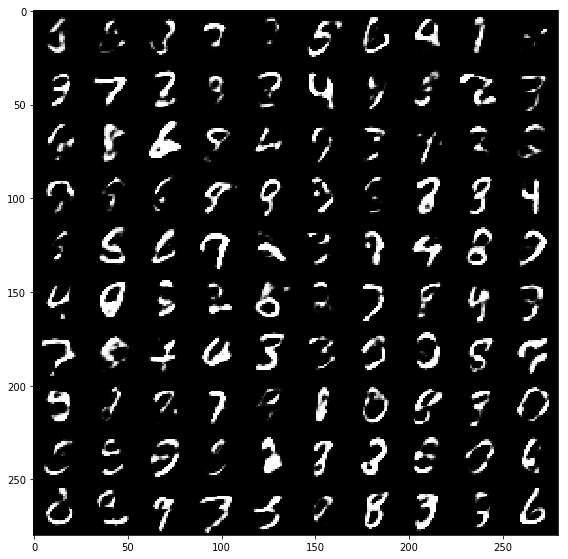

In [74]:
nx = ny = 10
sample_num = 100
canvas = np.empty((28*ny, 28*nx))
sample_lantent_code = sess.run(sample_gumbel([sample_num*N, K]))
print('debug')
print(type(sample_lantent_code))
print(sample_lantent_code.shape)
img = sess.run(output_img,{tau:0.1, y:np.reshape(sample_lantent_code, [-1, N, K])})
print('debug2')
img = np.reshape(img,[-1, 28, 28])
it = 0
for i in range(nx):
    for j in range(ny):
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = img[it]
        it += 1
plt.figure(figsize=(8, 10))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()
plt.show()        